In [3]:
import os
import pickle
import jax
import haiku as hk
import jax.numpy as jnp
import numpy as onp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from jax import random
matplotlib.use('Agg')

from utils.graphics import FOURIER_CMAP
from utils.ntk import ntk_eigendecomposition, get_ntk

from scipy.io import loadmat, savemat

### **Models**

- Wire-Finer
- Gauss-Finer
- Finer
- Siren
- FFN
- MLP

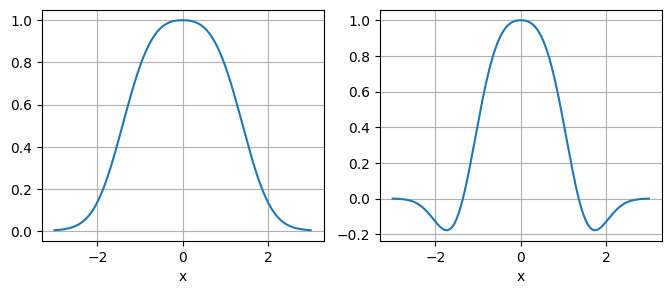

In [4]:
''' Activation Functions
'''
scale_fn = lambda x: jax.lax.stop_gradient(jnp.abs(x) + 1)

def finer_activation(x, w0=30):
    return jnp.sin(w0 * scale_fn(x) * x)

def gauss_activation(x, s0=30):
    return jnp.exp(-(s0*x)**2)

def gaussfiner_activation(x, s0=30, w0_finer=30):
    return gauss_activation(finer_activation(x, w0_finer), s0=s0)

def wire_activation(x, s0=30, w0=30):
    return jnp.exp(1j*w0*x - jnp.abs(s0*x)**2)

def wirefiner_activation(x, s0=30, w0=30, w0_finer=30):
    return wire_activation(finer_activation(x, w0_finer), s0=s0, w0=w0)

''' Plot test
'''
x = jnp.linspace(-3, 3, 10000) 
y_gf = gaussfiner_activation(x, s0=2.5, w0_finer=0.1)                    # 1
y_wf = wirefiner_activation(x, s0=2.5, w0=5, w0_finer=0.1)         # default:10, 20; 1, 2 
plt.figure(figsize=(4*2, 3))
plt.subplot(1,2,1); plt.plot(x, y_gf); plt.xlabel('x'); plt.grid(True);
plt.subplot(1,2,2); plt.plot(x, y_wf.real); plt.xlabel('x'); plt.grid(True); 
plt.show()

In [5]:
''' Complex Wire-Finer 
    Complex Multiply: a+bi * c+di = (ac-bd) + (ad+bc)i
'''
class WFLayer(hk.Module):
    def __init__(self, in_f, out_f, s0=2.5, w0=5, w0_finer=0.4, bs=None, is_first=False, is_last=False):
        super().__init__()
        self.s0 = s0
        self.w0 = w0
        self.w0_finer = w0_finer
        self.in_f = in_f
        self.out_f = out_f
        self.is_last=is_last
        
        # weight init: sine init
        self.w_init_bound = 1/in_f if is_first else jnp.sqrt(6/in_f)/(w0*w0_finer)
        self.w_dtype = jnp.float32 if is_first else jnp.complex64
        
        # bias init: pytorch init or bs
        self.b_init_bound = 1/jnp.sqrt(in_f) if bs is None else bs
        
    def __call__(self, x):        
        # Complex/Float Weight
        w = hk.get_parameter("weight", [self.in_f, self.out_f], dtype=self.w_dtype, 
                             init=hk.initializers.RandomNormal(-self.w_init_bound, self.w_init_bound))
        # Complex/Float Bias
        b = hk.get_parameter("bias", [self.out_f], dtype=self.w_dtype, 
                             init=hk.initializers.RandomNormal(-self.b_init_bound, self.b_init_bound))
        # Forward 
        out = jnp.dot(x, w)
        b = jnp.broadcast_to(b, out.shape)
        out = out + b
        # Activate
        return out if self.is_last else wirefiner_activation(out, s0=self.s0, w0=self.w0, w0_finer=self.w0_finer)


class WireFINER(hk.Module):
    def __init__(self, s0, w0, w0_finer, width, depth, bs=None):
        super().__init__()
        self.s0 = s0  
        self.w0 = w0
        self.w0_finer = w0_finer
        self.width = width
        self.depth = depth
        self.bs = bs

    def __call__(self, coords):
        sh = coords.shape
        x = jnp.reshape(coords, [-1, 1]) # one dimension signal
        x = WFLayer(x.shape[-1], self.width, s0=self.s0, w0=self.w0, w0_finer=self.w0_finer, bs=self.bs, is_first=True)(x)
        
        for _ in range(self.depth - 2):
            x = WFLayer(x.shape[-1], self.width, s0=self.s0, w0=self.w0, w0_finer=self.w0_finer)(x)

        out = WFLayer(x.shape[-1], 1, s0=self.s0, w0=self.w0, w0_finer=self.w0_finer, is_last=True)(x)
        out = jnp.reshape(out, list(sh[:-1]) + [1])
        return jnp.real(out) if out.dtype==jnp.complex64 else out

''' test
    s=10; w=20 -> s=2.5; w=5; w_finer=4
'''
# model = hk.without_apply_rng(hk.transform(lambda x: WireFINER(s0=2.5, w0=5, w0_finer=4, width=64, depth=3, bs=10)(x)))
# coords = jnp.array([1.0, 2.0, 3.0]).reshape(-1, 1); print(coords.shape)
# params = model.init(random.PRNGKey(0), jnp.ones((1, 1)))
# output = model.apply(params, coords)
# print(output) 

' test\n    s=10; w=20 -> s=2.5; w=5; w_finer=4\n'

In [6]:
''' Gauss-Finer
'''
class GFLayer(hk.Module):
    def __init__(self, in_f, out_f, s0=2.5, w0_finer=2, bs=None, is_first=False, is_last=False):
        super().__init__()
        self.s0 = s0
        self.w0_finer = w0_finer
        self.out_f = out_f
        self.is_last=is_last
        
        # weight init: sine init
        self.w_init_bound = 1/in_f if is_first else jnp.sqrt(6/in_f)/w0_finer
        
        # bias init: pytorch init or bs
        self.b_init_bound = 1/jnp.sqrt(in_f) if bs is None else bs        
        
    def __call__(self, x):
        x = hk.Linear(
            output_size=self.out_f,
            w_init=hk.initializers.RandomUniform(-self.w_init_bound, self.w_init_bound),
            b_init=hk.initializers.RandomUniform(-self.b_init_bound, self.b_init_bound),
        )(x)
        # Activate
        return x if self.is_last else gaussfiner_activation(x, s0=self.s0, w0_finer=self.w0_finer) 
        
        
class GaussFINER(hk.Module):
    def __init__(self, s0, w0_finer, width, depth, bs=None):
        super().__init__()
        self.s0 = s0  
        self.w0_finer = w0_finer
        self.width = width
        self.depth = depth
        self.bs = bs

    def __call__(self, coords):
        sh = coords.shape
        x = jnp.reshape(coords, [-1, 1]) # one dimension signal
        x = GFLayer(x.shape[-1], self.width, s0=self.s0, w0_finer=self.w0_finer, bs=self.bs, is_first=True)(x)
        
        for _ in range(self.depth - 2):
            x = GFLayer(x.shape[-1], self.width, s0=self.s0, w0_finer=self.w0_finer)(x)

        out = GFLayer(x.shape[-1], 1, s0=self.s0, w0_finer=self.w0_finer, is_last=True)(x)
        out = jnp.reshape(out, list(sh[:-1]) + [1])
        return out

''' test
    s=10 -> s=2.5; w_finer=4
'''
# model = hk.without_apply_rng(hk.transform(lambda x: GaussFINER(s0=2.5, w0_finer=4, width=64, depth=3, bs=10)(x)))
# coords = jnp.array([1.0, 2.0, 3.0]).reshape(-1, 1); print(coords.shape)
# params = model.init(random.PRNGKey(0), jnp.ones((1, 1)))
# output = model.apply(params, coords)
# print(output) 

' test\n    s=10 -> s=2.5; w_finer=4\n'

In [7]:
#################################### FINER ####################################
class FinerLayer(hk.Module):
    def __init__(self, in_f, out_f, w0=30, bs=None, is_first=False, is_last=False):
        super().__init__()
        self.w0 = w0
        self.is_first = is_first
        self.is_last = is_last
        self.out_f = out_f
        self.b = 1 / in_f if self.is_first else jnp.sqrt(6 / in_f) / w0
        self.b_init = None
        if bs:
            self.b_init = hk.initializers.RandomUniform(-bs, bs)
        
    def __call__(self, x):
        x = hk.Linear(
            output_size=self.out_f,
            w_init=hk.initializers.RandomUniform(-self.b, self.b),
            b_init=self.b_init,
        )(x)
        scale = scale_fn(x)
        return x + 0.5 if self.is_last else self.w0 * scale * x


class FINER(hk.Module):
    def __init__(self, w0, width, hidden_w0, depth, bs=None):
        super().__init__()
        self.w0 = w0  
        self.width = width
        self.depth = depth
        self.hidden_w0 = hidden_w0
        self.bs = bs

    def __call__(self, coords):
        sh = coords.shape
        x = jnp.reshape(coords, [-1, 1]) # one dimension signal
        x = FinerLayer(x.shape[-1], self.width, is_first=True, w0=self.w0, bs=self.bs)(x)
        x = jnp.sin(x)

        for _ in range(self.depth - 2):
            x = FinerLayer(x.shape[-1], self.width, w0=self.hidden_w0)(x)
            x = jnp.sin(x)

        out = FinerLayer(x.shape[-1], 1, w0=self.hidden_w0, is_last=True)(x)
        out = jnp.reshape(out, list(sh[:-1]) + [1])
        return out

#################################### SIREN ####################################

class SIRENLayer(hk.Module):
    def __init__(self, in_f, out_f, w0=200, bs=None, is_first=False, is_last=False):
        super().__init__()
        self.w0 = w0
        self.is_first = is_first
        self.is_last = is_last
        self.out_f = out_f
        self.b = 1 / in_f if self.is_first else jnp.sqrt(6 / in_f) / w0
        self.bi = None
        if bs:
            self.bi = hk.initializers.RandomUniform(-bs, bs)

    def __call__(self, x):
        x = hk.Linear(
            output_size=self.out_f,
            w_init=hk.initializers.RandomUniform(-self.b, self.b),
            b_init=self.bi,
        )(x)
        return x + 0.5 if self.is_last else self.w0 * x
    

class SIREN(hk.Module):
    def __init__(self, w0, width, hidden_w0, depth, bs=None):
        super().__init__()
        self.w0 = w0  # to change the omega_0 of SIREN !!!!
        self.width = width
        self.depth = depth
        self.hidden_w0 = hidden_w0
        self.bs = bs

    def __call__(self, coords):
        sh = coords.shape
        x = jnp.reshape(coords, [-1, 1])
        x = SIRENLayer(x.shape[-1], self.width, is_first=True, w0=self.w0, bs=self.bs)(x)
        x = jnp.sin(x)

        for _ in range(self.depth - 2):
            x = SIRENLayer(x.shape[-1], self.width, w0=self.hidden_w0)(x)
            x = jnp.sin(x)

        out = SIRENLayer(x.shape[-1], 1, w0=self.hidden_w0, is_last=True)(x)
        out = jnp.reshape(out, list(sh[:-1]) + [1])

        return out
    

######################################

class MLP(hk.Module):
    def __init__(self, width, depth):
        super().__init__()
        self.width = width
        self.depth = depth

    def __call__(self, coords):
        sh = coords.shape

        x = jnp.reshape(coords, [-1, 1])
        x = hk.Linear(self.width)(x)
        x = jax.nn.relu(x)

        for _ in range(self.depth - 2):
            x = hk.Linear(self.width)(x)
            x = jax.nn.relu(x)

        out = hk.Linear(1)(x)
        out = jnp.reshape(out, list(sh[:-1]) + [1])

        return out

######################################

class FFN(hk.Module):
    def __init__(self, sigma, width, depth):
        super().__init__()
        self.sigma = sigma
        self.width = width
        self.depth = depth
        self.B = self.sigma * jax.random.normal(jax.random.PRNGKey(7), (width, 1))

    def __call__(self, coords):
        sh = coords.shape
        x = jnp.reshape(coords, [-1, 1])
        x = input_mapping_fourier(x, self.B)

        for _ in range(self.depth - 2):
            x = hk.Linear(self.width)(x)
            x = jax.nn.relu(x)

        out = hk.Linear(1)(x)
        out = jnp.reshape(out, list(sh[:-1]) + [1])

        return out


def input_mapping_fourier(x, B):
    if B is None:
        return x
    else:
        x_proj = (2.0 * jnp.pi * x) @ B.T
        return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)


In [8]:
def show_ntk(
    model,
    params,
    data,
    batch_size,
    logdir,
    keyword="",
    colorbar=False,
):
    outdir = logdir

    ntk_matrix = get_ntk(model.apply, params, data, batch_size)

    plt.figure()
    plt.imshow(ntk_matrix, cmap='inferno')
    plt.axis('off')
    plt.savefig(outdir + os.path.sep + keyword + "_ntk_matrix" + ".png", bbox_inches="tight", pad_inches=0)
    if colorbar:
        plt.colorbar()
    plt.close('all')
    
    return ntk_matrix

In [9]:
'''run above'''

'run above'

### **NTK Visualization**

In [ ]:
DEFAULT_RESOLUTION = 1024
x1 = jnp.linspace(0, 1, DEFAULT_RESOLUTION + 1)[:-1]
# x1 = jnp.linspace(-1, 1, DEFAULT_RESOLUTION + 1)[:-1]
DEFAULT_GRID = x1
BATCH_SIZE = 128
DEFAULT_GRID = jnp.reshape(DEFAULT_GRID, [-1, 1])

width=256
depth=1

logdir = os.path.join(os.getcwd(), 'outputs', 'Finer')
os.makedirs(logdir, exist_ok=True)

first_omegas = [1]
hidden_omegas = [30]
bias_scale = [1, 5, 10, 20] 

outputs = {}
save_ntk_path = os.path.join(logdir, 'ntks.mat')
if os.path.exists(save_ntk_path):
    outputs = loadmat(save_ntk_path)
for k in outputs:
    print(k)

for hw0 in hidden_omegas: 
    for fw0 in first_omegas:
        for bs in bias_scale:
            model_finer = hk.without_apply_rng(hk.transform(lambda x: FINER(w0=fw0, width=width, hidden_w0=hw0, depth=depth, bs=bs)(x)))
            if bs == None:
                bs = 0
            
            key = f'finer_fw{fw0}_hw{hw0}_bs_{bs}_ntkmatrix'
            if key in outputs:
                continue
                
            params_finer = model_finer.init(random.PRNGKey(0), jnp.ones((1, 1)))
            
            ntk_matrix = show_ntk(
                model_finer,
                params_finer,
                keyword=f"finer_bs{bs}",
                data=DEFAULT_GRID,
                batch_size=BATCH_SIZE,
                logdir=logdir
            )            
            outputs[key] = ntk_matrix
            
savemat(save_ntk_path, outputs)

In [ ]:
''' Gauss-Finer
'''
DEFAULT_RESOLUTION = 1024
DEFAULT_GRID = jnp.linspace(0, 1, DEFAULT_RESOLUTION + 1)[:-1]
BATCH_SIZE = 128
DEFAULT_GRID = jnp.reshape(DEFAULT_GRID, [-1, 1])

## params 
width=256
depth=1
s0 = 2.5
w0_finer = 0.4
bias_scale = [1, 5, 10, 20] 

expname = f'gaussfiner_s0[{s0}]_w0f[{w0_finer}]'

## logdir 
logdir = os.path.join(os.getcwd(), 'outputs', expname); os.makedirs(logdir, exist_ok=True)

## save 
outputs = {}
save_ntk_path = os.path.join(logdir, f'{expname}_ntks.mat')
if os.path.exists(save_ntk_path):
    outputs = loadmat(save_ntk_path)
# for k in outputs:
#     print(k)
    
## Run
for bs in bias_scale:
    model = hk.without_apply_rng(hk.transform(lambda x: GaussFINER(s0=s0, w0_finer=w0_finer, width=width, depth=depth, bs=bs)(x)))
    
    key = f'net_bs_{bs}'
    if key in outputs:
        continue
        
    params = model.init(random.PRNGKey(0), jnp.ones((1, 1)))
    ntk_matrix = show_ntk(
        model,
        params,
        keyword=key,
        data=DEFAULT_GRID,
        batch_size=BATCH_SIZE,
        logdir=logdir 
    )
    print(ntk_matrix.max(), ntk_matrix.min())
    outputs[key] = ntk_matrix

savemat(save_ntk_path, outputs)

In [ ]:
''' Wire-Finer
'''
DEFAULT_RESOLUTION = 1024
DEFAULT_GRID = jnp.linspace(0, 1, DEFAULT_RESOLUTION + 1)[:-1]
BATCH_SIZE = 128
DEFAULT_GRID = jnp.reshape(DEFAULT_GRID, [-1, 1])

## params 
width=256
depth=1
s0 = 2.5
w0 = 5
w0_finer = 0.08
bias_scale = [1, 5, 10, 20] 

expname = f'wirefiner_s0[{s0}]_w0[{w0}]_w0f[{w0_finer}]'

## logdir 
logdir = os.path.join(os.getcwd(), 'outputs', expname); os.makedirs(logdir, exist_ok=True)

## save 
outputs = {}
save_ntk_path = os.path.join(logdir, f'{expname}_ntk.mat')
if os.path.exists(save_ntk_path):
    outputs = loadmat(save_ntk_path)
# for k in outputs:
#     print(k)
    
## Run
for bs in bias_scale:
    model = hk.without_apply_rng(hk.transform(lambda x: WireFINER(s0=s0, w0=w0, w0_finer=w0_finer, width=width, depth=depth, bs=bs)(x)))
    
    key = f'net_bs_{bs}'
    if key in outputs:
        continue
        
    params = model.init(random.PRNGKey(0), jnp.ones((1, 1)))
    ntk_matrix = show_ntk(
        model,
        params,
        keyword=key,
        data=DEFAULT_GRID,
        batch_size=BATCH_SIZE,
        logdir=logdir 
    )
    print(ntk_matrix.max(), ntk_matrix.min())
    outputs[key] = ntk_matrix

savemat(save_ntk_path, outputs)

In [ ]:
# ## SIREN
# fw0 = 1
# hw0 = 30
# bias_scale = [None, 0.5, 1, 3, 5, 10, 20, 30, 40]

# for bs in bias_scale:
#     model_SIREN = hk.without_apply_rng(hk.transform(lambda x: SIREN(w0=fw0, width=width, hidden_w0=hw0, depth=depth, bs=bs)(x)))
#     params_SIREN = model_SIREN.init(random.PRNGKey(0), jnp.ones((1, 1)))
    
#     if bs == None:
#         bs = 0
        
#     key = f'siren_fw{fw0}_hw{hw0}_bs_{bs}_ntkmatrix'
#     if key in outputs:
#         continue        
    
#     ntk_matrix = show_ntk(
#         model_SIREN,
#         params_SIREN,
#         keyword=f"siren_bs_{bs}",
#         data=DEFAULT_GRID,
#         batch_size=BATCH_SIZE,
#     )
    
#     outputs[key] = ntk_matrix
#     print(ntk_matrix.max(), ntk_matrix.min())

# savemat(save_ntk_path, outputs)

In [ ]:
# ## MLP
# model_mlp = hk.without_apply_rng(hk.transform(lambda x: MLP(width=width, depth=depth)(x)))
# params_mlp = model_mlp.init(random.PRNGKey(0), jnp.ones((1, 1)))

# key = f'mlp_ntkmatrix'
# if key not in outputs:
#     ntk_matrix = show_ntk(
#         model_mlp,
#         params_mlp,
#         keyword=f"mlp",
#         data=DEFAULT_GRID,
#         batch_size=BATCH_SIZE,
#     )
#     outputs[key] = ntk_matrix
#     print(ntk_matrix.max(), ntk_matrix.min())
#     savemat(save_ntk_path, outputs)

In [ ]:
# ## FFN: OK 
# model_FFN_1 = hk.without_apply_rng(hk.transform(lambda x: FFN(sigma=1, width=width, depth=depth)(x)))
# params_FFN_1 = model_FFN_1.init(random.PRNGKey(0), jnp.ones((1, 1)))

# model_FFN_10 = hk.without_apply_rng(hk.transform(lambda x: FFN(sigma=10, width=width, depth=depth)(x)))
# params_FFN_10 = model_FFN_10.init(random.PRNGKey(0), jnp.ones((1, 1)))

# key = f'ffn_10_ntkmatrix'
# if key not in outputs:
#     ntk_matrix_ffn_10 = show_ntk(
#         model_FFN_10,
#         params_FFN_10,
#         keyword="ffn_10",
#         data=DEFAULT_GRID,
#         batch_size=BATCH_SIZE,
#     )
#     outputs[key] = ntk_matrix_ffn_10
#     savemat(save_ntk_path, outputs)

# key = f'ffn_1_ntkmatrix'
# if key not in outputs:
#     ntk_matrix_ffn_1 = show_ntk(
#         model_FFN_1,
#         params_FFN_1,
#         keyword="ffn_1",
#         data=DEFAULT_GRID,
#         batch_size=BATCH_SIZE,
#     )
#     outputs[key] = ntk_matrix_ffn_1
#     savemat(save_ntk_path, outputs)


In [ ]:
# ## test
# divmax_logdir = os.path.join(logdir, 'DivMax')
# os.makedirs(divmax_logdir, exist_ok=True)

# outputs = loadmat(save_ntk_path)
# for k in outputs:
#     if k in ['__header__', '__version__', '__globals__']:
#         continue
#     ntk_mat = outputs[k]
#     print(k, '    ', ntk_mat.max(), ntk_mat.min())
#     # ntk_mat /= 260
    
#     norm = matplotlib.colors.Normalize(vmin=0, vmax=507)
    
#     plt.imshow(ntk_mat, cmap='inferno', norm=norm)
#     plt.colorbar()
#     plt.axis('off')
#     plt.savefig(divmax_logdir + os.path.sep + k + "_ntk_matrix.png", bbox_inches="tight", pad_inches=0)
#     plt.close('all')
    

    

In [ ]:
# import numpy as onp
# from scipy.io import savemat, loadmat

# # finer
# outs = onp.load('ntk_mat/ntks.npy', allow_pickle=True).item()
# for k in outs:
#     print(k)

# savemat('ntk_mat/ntks_finer.mat', outs)

# # siren
# outs = onp.load('ntk_mat/ntks_siren.npy', allow_pickle=True).item()
# for k in outs:
#     print(k)
# savemat('ntk_mat/ntks_siren.mat', outs)


# mats = loadmat('ntk_mat/ntks_finer.mat')

# # for k in mats:
# #     print(k)
    
    
# mats = loadmat('ntk_mat/ntks_siren.mat')

# for k in mats:
#     print(k)
